In [ ]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import pandas as pd
import random as rd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import transforms, utils
from torchvision.io import read_image

In [ ]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)
image_path='./data/images_gz2/images'

100% (3281862708 of 3281862708) |########| Elapsed Time: 0:00:38 Time:  0:00:38
Extracting : 100%|██████████| 243438/243438 [00:58<00:00, 4180.50it/s]


In [ ]:
'''
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.transform = transform
        self.img_dir = img_dir
        
        images=glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
    
        cut=int(0.1*len(images)/10000)
        if train:
            self.images = images[:cut]
        else:
            self.images = images[cut:]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        img_path=self.images[index]
        image = read_image(img_path)/255
        image = image.float()
        if self.transform:
            image = self.transform(image)
        return image
'''
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
        cut = int(0.1*len(images)/10)
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        with Image.open(img_path) as im:
            if self.transform:
                im = self.transform(im)
            return im.float()/255

torch.Size([4, 3, 424, 424])


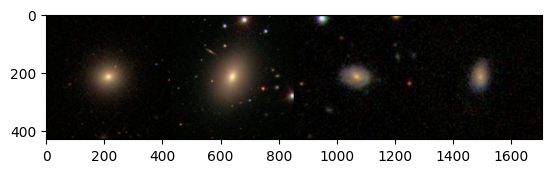

In [ ]:
#check that dataset is OK and has been correctly loaded
trainset=GalaxyZoo2(image_path, transform=transforms.PILToTensor())
trainloader=DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 28 #images are 424*424
input_channels = 3 #bc images are RGB in this case (the corresponding tensors are of size [3,424,424])
batch_size = 12 #try to chnage later

#hyperparameters of the NN specifically
input_features = input_channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 32 # size of output of encoder = input of decoder
hidden_features = 10 # arbitrary
hidden_features2 = 5 # arbitrary
hidden_features3 = 1 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 1e-3 # arbitrary
num_epochs = 10 # arbitrary

model_name = "CNN_GAN"

#transforms.Normalize(0.5,0.5),transforms.Resize([image_size,image_size]),),
T = transforms.Compose([transforms.PILToTensor(),transforms.Resize([image_size,image_size]),])

#directory = ""
#checkpoint = f"{directory}/{model_name}.pt"

this instance use cuda


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([12, 3, 28, 28])


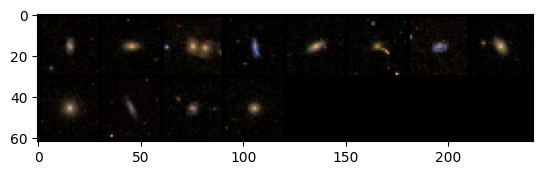

In [ ]:
#check that dataset is OK and has been correctly loaded
trainset=GalaxyZoo2(image_path, transform=T)
trainloader=DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [ ]:
class CNN_GAN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            ############### conv part ###############
            #try convolutional but with big kernel
            nn.Linear(6272,6272),
            nn.ReLU(),

            nn.Unflatten(0,[1,128,7,7]),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,3,1,padding='same'),
            
            nn.Sigmoid()
            )
    '''
    nn.Linear(6272,6272),
    nn.ReLU(),
    nn.Unflatten(0,[1,128,7,7]),
    nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,128,1,padding='same'),
            nn.ReLU(),

            nn.Conv2d(128,3,1,padding='same'),
    '''
    def forward(self, x):
      return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(3,32,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(64,128,5),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Conv2d(128,256,5),
            nn.ReLU(),

            nn.Flatten(),
            nn.Dropout(p=0.2),
            
            nn.Linear(36864,1),
            
            nn.Sigmoid()
            )
      
    def forward(self, x):
      return self.encoder(x)

torch.Size([1, 3, 28, 28])


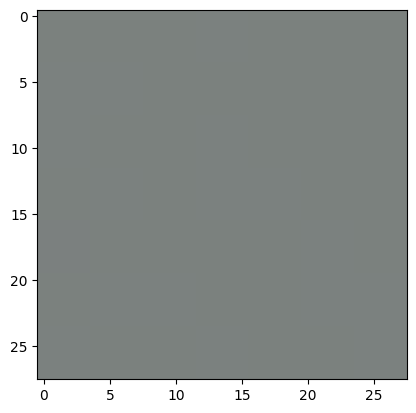

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

tensor([[0.5024],
        [0.5046],
        [0.5014],
        [0.5028],
        [0.5019],
        [0.5035],
        [0.5022],
        [0.5011],
        [0.5032],
        [0.5032],
        [0.5017],
        [0.5028]], device='cuda:0', grad_fn=<SigmoidBackward0>)


'\ntest_image=next(iter(trainloader))\ntest_image#.to(device)\nprint(test_image.shape)\ntest=model(test_image.to(device))\n#show_images(utils.make_grid(test))\nprint(test.shape)\n'

In [ ]:
trainset = GalaxyZoo2(image_path, transform=T, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#model = MLP_VAE(input_dim=input_features).to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#GPUtil.showUtilization()
model = CNN_GAN().to(device)
disc = Discriminator().to(device)

#model = nn.DataParallel(model, gpu_ids = [0,1,2])

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


g_opt = optim.Adam(model.parameters(), lr=learning_rate)
d_opt = optim.Adam(disc.parameters(), lr=learning_rate)
g_loss = nn.BCELoss()
d_loss = nn.BCELoss()



test = model(torch.randn(7*7*128).to(device))
print(test.shape)
show_images(utils.make_grid(test))

test_image=next(iter(trainloader))
result = disc(test_image.to(device))
print(result)

'''
test_image=next(iter(trainloader))
test_image#.to(device)
print(test_image.shape)
test=model(test_image.to(device))
#show_images(utils.make_grid(test))
print(test.shape)
'''

In [ ]:
images=next(iter(trainloader))
y_true = torch.zeros(batch_size)
y_false = torch.ones(batch_size)
print(torch.cat((y_true,y_false),0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])


In [ ]:
def train(num_epochs):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    
    for i in range(num_epochs):
        train_losses = []
        real_images = next(iter(trainloader))
        fake_images = torch.rand([batch_size,3,28,28])

        real_images = real_images.to(device)
        fake_images = fake_images.to(device)
        
        y_d_true = torch.ones(batch_size)
        y_d_false = torch.ones(batch_size)

        for j in range(batch_size) :
          y_d_true[j] = disc(torch.unsqueeze(real_images[j,:,:,:],-4))
          y_d_false[j] = disc(torch.unsqueeze(fake_images[j,:,:,:],-4))


        y_true = torch.zeros(batch_size) + 0.15*torch.rand(batch_size)
        y_false = torch.ones(batch_size) - 0.15*torch.rand(batch_size)
        
        y_realfake = torch.cat((y_true,y_false),0)
        y_d_realfake = torch.cat((y_d_true,y_d_false),0)

        L_d = d_loss(y_realfake, y_d_realfake)

        d_opt.zero_grad()
        L_d.backward()
        d_opt.step()

        for j in range(batch_size) :
          gen_images = model(torch.rand(7*7*128).to(device))
          L_g = disc(gen_images)

          g_opt.zero_grad()
          L_g.backward()
          g_opt.step()
          

        train_avg_loss.append(L_d)
    return train_avg_loss
          

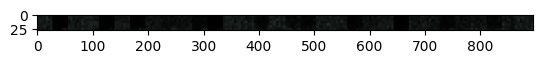

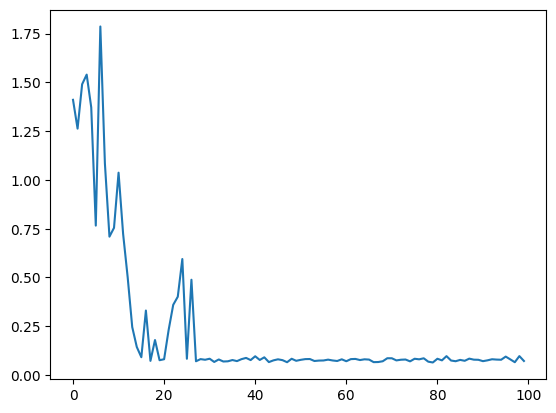

In [ ]:
test = torch.tensor([]).to(device)
for i in range(32) :
  test = torch.cat([test,model(torch.randn(7*7*128).to(device))],-1)
show_images(utils.make_grid(test))
plt.plot(torch.tensor(L))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

"\nmodel=model.to(device)\n\ntrain_avg_loss = train(num_epochs)\n\nfig = plt.figure()\n\nplt.plot(train_avg_loss)\nplt.title('ELBO loss of the VAE')\nplt.xlabel('Iterations')\nplt.ylabel('Loss (ELBO)')\n\nplt.show()\n"

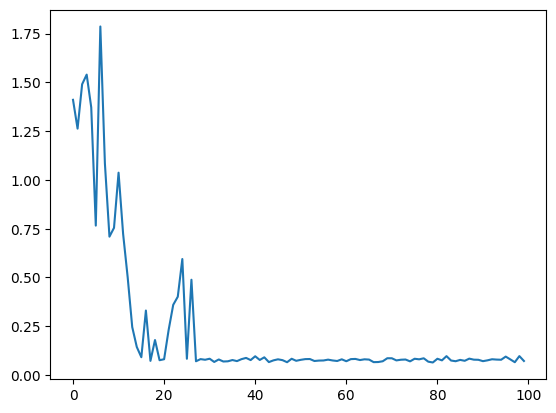

In [ ]:
num_epochs=100
L = train(num_epochs)
plt.plot(torch.tensor(L))

'''
model=model.to(device)

train_avg_loss = train(num_epochs)

fig = plt.figure()

plt.plot(train_avg_loss)
plt.title('ELBO loss of the VAE')
plt.xlabel('Iterations')
plt.ylabel('Loss (ELBO)')

plt.show()
'''

In [ ]:
 def train_GAN(num_epochs):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    
    for i in range(num_epochs):
        for j in range(batch_size) :
          gen_images = model(torch.rand(7*7*128).to(device))
          L_g = disc(gen_images)

          g_opt.zero_grad()
          L_g.backward()
          g_opt.step()
          

        train_avg_loss.append(L_g)
    return train_avg_loss



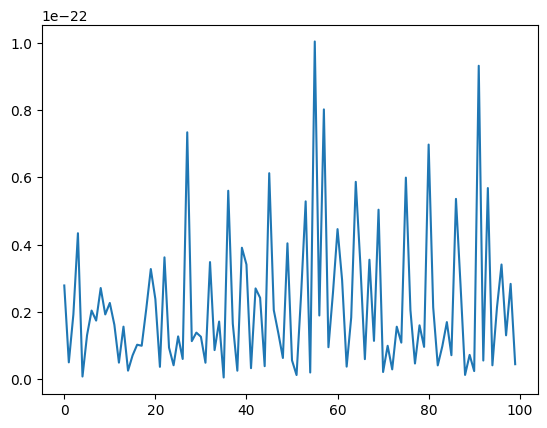

In [ ]:
L = train_GAN(100)
plt.plot(torch.tensor(L))

In [ ]:
plt.plot(torch.tensor(L))
plt.xlabel('Number of epochs')
plt.ylabel('Average Loss')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 106 #images are 424*424
input_channels = 3 #bc images are RGB in this case (the corresponding tensors are of size [3,424,424])
batch_size = 20 #try to chnage later

#hyperparameters of the NN specifically
input_features = input_channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 32 # size of output of encoder = input of decoder
hidden_features = 10 # arbitrary
hidden_features2 = 5 # arbitrary
hidden_features3 = 1 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 1e-3 # arbitrary
num_epochs = 10 # arbitrary

model_name = "CNN_VAE"

T = transforms.Compose([transforms.PILToTensor(),transforms.Resize([image_size,image_size])])

#directory = ""
#checkpoint = f"{directory}/{model_name}.pt"

this instance use cuda


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([20, 3, 106, 106])


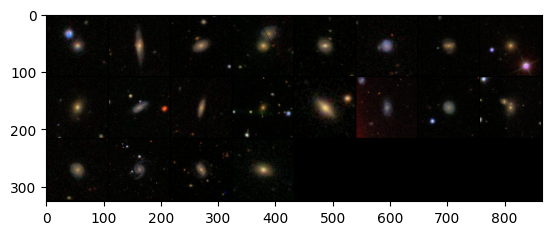

In [ ]:
#check that dataset is OK and has been correctly loaded
trainset=GalaxyZoo2(image_path, transform=T)
trainloader=DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [ ]:
class CNN_VAE(nn.Module):
    def __init__(self, input_dim, output_dim=32, latent_dim=2):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(input_dim,hidden_features,kernel_size=(5,5)),
            nn.ReLU(),
            nn.Conv2d(hidden_features,hidden_features2,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(hidden_features2,hidden_features2,kernel_size=(5,5)),
            nn.ReLU(),
            nn.Conv2d(hidden_features2,hidden_features3,kernel_size=(5,5)),
            nn.ReLU(),
            nn.Conv2d(hidden_features3,hidden_features3,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(), #necessary to flatten before linear bc go from 4d to 2d
            
            ############### fully-connected part ###############
            nn.Linear(hidden_features3*input_channels*image_size*image_size,1024), #the 539328 is from the tests, don't know why this particular value
            #nn.Linear(batch_size,20),
            nn.ReLU(),
            nn.Linear(1024,output_features),
            nn.Softmax(), #output
            )
        
        self.mu = nn.Linear(output_dim, latent_dim)
        self.logvar = nn.Linear(output_dim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, output_dim)
        
        self.decoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(output_features,hidden_features,kernel_size=(5,5)),
            nn.ReLU(),
            nn.Conv2d(hidden_features,hidden_features,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(input_dim,hidden_features,kernel_size=(5,5)),
            nn.ReLU(),
            nn.Conv2d(hidden_features,hidden_features,kernel_size=(5,5)),
            nn.ReLU(),
            #nn.MaxPool2d(2,2),
            
            nn.Flatten(), #necessary to flatten before linear bc go from 4d to 2d
            #Flatten should allow to avoid doing a view for this purpose
            
            ############### fully-connected part ###############
            nn.Linear(539328,1024), #the 539328 is from the tests, don't know why this particular value
            #nn.Linear(batch_size,20),
            nn.ReLU(),
            nn.Linear(1024,output_features),
            nn.Softmax(), #output
            )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [ ]:
trainset = GalaxyZoo2(image_path, transform=T, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#model = MLP_VAE(input_dim=input_features).to(device)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#GPUtil.showUtilization()
model = CNN_VAE(input_dim=batch_size).to(device)

#model = nn.DataParallel(model, gpu_ids = [0,1,2])

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(num_epochs):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    loop = tqdm(enumerate(trainloader))
    
    for i in range(num_epochs):
        train_losses = []
        loop
        
        for i,x in loop:
            x = x.to(device).view(x.shape[0],-1)
            x_reconstructed, mu, logvar = model(x)
        
            loss = ElboLoss(x, x_reconstructed, mu, logvar)
            optimizer.zero_grad()
            #loss.backward()
            loss.mean().backward() #necessary to mean bc use several parallel GPUs = mean the losses from each of them
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.detach())
                    
        train_avg_loss.append(torch.mean(torch.FloatTensor(train_losses)))

    return train_avg_loss #we could also return the reconstruction loss and the regularization loss individually, but in the end it is the EL

In [ ]:
num_epochs=10
model=model.to(device)

train_avg_loss = train(num_epochs)

fig = plt.figure()

plt.plot(train_avg_loss)
plt.title('ELBO loss of the VAE')
plt.xlabel('Iterations')
plt.ylabel('Loss (ELBO)')

plt.show()

In [ ]:
model=model.to(device)
images=next(iter(trainloader))
images = images.to(device)
test,mu,logvar=model(images.view(images.shape[0],-1))
show_images(utils.make_grid(test.view(test.shape[0],3,424,424)[0]))

ma partire qui pue

torch.Size([3, 424, 424])


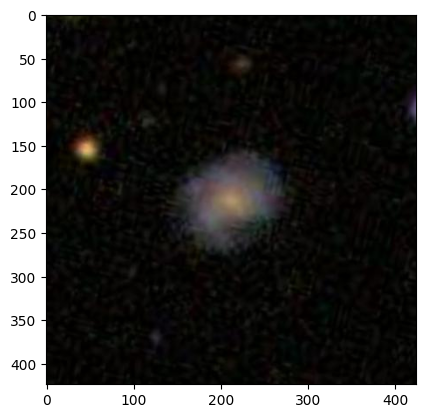

In [ ]:
'''
transform = transforms.Compose([
    transforms.Resize([106,106]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter()
])
'''
transform = None
trainloader=GalaxyZoo2(image_path,transform=transform)
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class MLP_GAN(nn.Module):
    
    def __init__(self):
        self.img_dim = 3*424*424
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(0),
            torch.nn.Linear(self.img_dim, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, self.img_dim),
            torch.nn.Unflatten(0,(3,424,424))
        )
        
        
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
        
    def forward(self, x):
        img_to_tensor = transforms.Compose([transforms.PILToTensor()])
        #x = img_to_tensor(x)
        #x = torch.reshape(x,(1,self.img_dim))
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class MLP_Discriminator(nn.Module):
    
    def __init__(self):
        self.img_dim = 3*424*424
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(0),
            torch.nn.Linear(self.img_dim, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        img_to_tensor = transforms.Compose([transforms.PILToTensor()])
        #x = img_to_tensor(x)
        #x = torch.reshape(x,(1,self.img_dim))
        encoded = self.encoder(x)
        return encoded

In [ ]:
class CNN_GAN(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        real_dim = input_dim[0]*input_dim[1]*input_dim[2]
        self.encoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(3,2,kernel_size=(10,10)),
            nn.ReLU(),
            nn.Conv2d(2,1,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            )
        
        self.decoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(1,2,kernel_size=(5,5)),
            nn.ReLU(),
            #nn.MaxPool2d(2,2),
            nn.Conv2d(2,3,kernel_size=(5,5))
            )
    
    
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        img_to_tensor = transforms.Compose([transforms.PILToTensor()])
        #x = img_to_tensor(x)
        #x = torch.reshape(x,(1,self.img_dim))
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class CNN_Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim=32, latent_dim=2):
        super().__init__()
        
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        real_dim = input_dim[0]*input_dim[1]*input_dim[2]
        self.encoder = nn.Sequential(
            ############### conv part ###############
            nn.Conv2d(3,2,kernel_size=(10,10)),
            nn.ReLU(),
            nn.Conv2d(2,1,kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            torch.nn.Sigmoid()
        )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        img_to_tensor = transforms.Compose([transforms.PILToTensor()])
        #x = img_to_tensor(x)
        #x = torch.reshape(x,(1,self.img_dim))
        encoded = self.encoder(x)
        return encoded

In [ ]:
#network = MLP_GAN()
#network = network.to(device)
#disc = MLP_Discriminator()
#disc = disc.to(device)
input_dim = [3,106,106]
network = CNN_GAN(input_dim)
network = network.to(device)
disc = CNN_Discriminator(input_dim)
disc = disc.to(device)
learning_rate = 0.01
#criterion = nn.BCELoss()
criterion = nn.L1Loss()
optimizer_disc = torch.optim.Adam(network.parameters(), lr=learning_rate)
optimizer_net = torch.optim.Adam(network.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize(input_dim[1:]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter()
])

In [ ]:
trainset=GalaxyZoo2(image_path,transform=transform)
print(len(trainset))
#trainset = trainset[:50]

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2


In [ ]:
def train_disc(num_epochs):
    train_losses_true = []
    train_losses_false = []

    for i in range(num_epochs):
        print(i)
        
        
        for y_true in trainset:
            y_true = y_true.to(device)
            pred = disc(y_true)
            loss = criterion(torch.tensor([0.]).to(device), pred)
            train_losses_true.append(loss.detach())
            
            optimizer_disc.zero_grad()
            loss.backward()
            optimizer_disc.step()
            
            y_false = torch.rand((3, 424,424))*2 -1
            y_false = y_false.to(device)
            pred = disc(y_false)
            loss = criterion(torch.tensor([1.]).to(device), pred)
            train_losses_false.append(loss.detach())
            
            optimizer_disc.zero_grad()
            loss.backward()
            optimizer_disc.step()

    return train_losses_true, train_losses_false


def train_gen(num_epochs):
    train_loss = []
    for i in range(num_epochs):
        print(i)
        x_in = torch.rand((3,424,424))*2 -1
        x_in = x_in.to(device)
        pred = network(x_in)
        guess = disc(pred)
        loss = criterion(torch.tensor([0.]).to(device), guess)
        
        optimizer_net.zero_grad()
        loss.backward()
        optimizer_net.step()
        
        train_loss.append(loss.detach())
    
    return train_loss

In [ ]:
a,b = train_disc(10)
c = train_gen(20)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


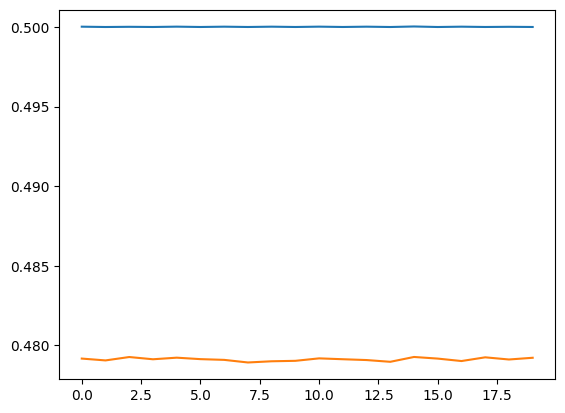

In [ ]:
plt.plot(torch.tensor(a))
plt.plot(torch.tensor(b))

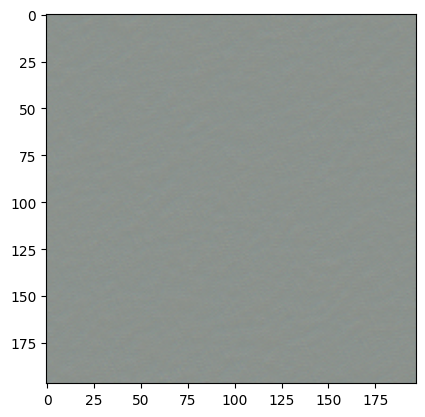

In [ ]:
#inv_tensor = trainset[0]*0.5 + 0.5
#show_images(utils.make_grid(inv_tensor))
x_in = torch.rand((3,424,424))*2 -1
x_in = x_in.to(device)
img = network(x_in)
img_denormalized = img*0.5 + 0.5
show_images(utils.make_grid(img_denormalized))
plt.show()

In [ ]:
img.shape


torch.Size([3, 197, 197])